# Preprocessing

## Team Name: JXCKJ
Haowen (Jason) Xiong: **haowenxiong**

Xiaoyan Qiu: **qxyanbb**

Caribel Florentino: **ccfloren-su**

Katherine Shapiro: **katieshapiro1**

Joyce Lin (POC): **jlin119**

### Combining Data Sets

First we combined all of our real estate datasets from 2010 to 2025. We removed unnecessary columns and fixed column names.

In [1]:
import pandas as pd

pd.set_option('display.float_format', '{:,.2f}'.format)

def find_borough_row(file_path):
    temp_df=pd.read_csv(file_path, header=None)
    borough_row=temp_df[temp_df.apply(lambda row: row.astype(str).str.contains('BOROUGH', case=False).any(), axis=1)].index[0]
    return borough_row

years=[str(year) for year in range(2010, 2025)]
boroughs=['bronx', 'brooklyn', 'manhattan', 'queens', 'statenisland']

exclude_columns=[
    'TAX CLASS AS OF FINAL ROLL 17/18',
    'BUILDING CLASS AS OF FINAL ROLL 17/18',
    'TAX CLASS AS OF FINAL ROLL 18/19',
    'BUILDING CLASS AS OF FINAL ROLL 18/19',
    'TAX CLASS AT PRESENT',
    'BLOCK',
    'LOT',
    'BUILDING CLASS AT PRESENT',
    'APARTMENT NUMBER',
    'RESIDENTIAL UNITS',
    'COMMERCIAL UNITS',
    'TOTAL UNITS',
    'TAX CLASS AT TIME OF SALE',
    'BUILDING CLASS AT TIME OF SALE',
    'EASE-MENT'
]

numeric_columns=[
    'RESIDENTIAL UNITS', 'COMMERCIAL UNITS', 'TOTAL UNITS',
    'LAND SQUARE FEET', 'GROSS SQUARE FEET', 'SALE PRICE'
]

dfs = []

for year in years:
    for borough in boroughs:
        file_path=f"/workspaces/student-group-project-jxckj/_datasets/{year}_{borough}.csv"
        borough_row=find_borough_row(file_path)
        df=pd.read_csv(file_path, skiprows=borough_row)
        df.columns=df.columns.str.strip()
        df.columns=df.columns.str.replace(r'\n+', ' ', regex=True).str.replace(r'\s+', ' ', regex=True).str.strip()
        df=df.dropna(how='all')
        df=df.dropna(axis=1, how='all')
        df=df.drop(columns=[col for col in exclude_columns if col in df.columns], errors='ignore')
        for col in numeric_columns:
            if col in df.columns:
                df[col]=df[col].astype(str).str.replace(r'[^\d.]', '', regex=True).str.strip()
                df[col]=pd.to_numeric(df[col], errors='coerce')
        dfs.append(df)

large_df=pd.concat(dfs, ignore_index=True)
large_df.columns = large_df.columns.str.replace(" ", "_")

### Data Exploration

In [3]:
large_df.head()

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,ADDRESS,ZIP_CODE,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,SALE_PRICE,SALE_DATE
0,2.00,BATHGATE,01 ONE FAMILY HOMES,4445 PARK AVENUE,"10,457.00","1,694.00","1,497.00","1,899.00",0.00,1/15/2010
1,2.00,BATHGATE,01 ONE FAMILY HOMES,441 EAST 178 STREET,"10,457.00","1,287.00","2,378.00","1,899.00","116,000.00",7/1/2010
2,2.00,BATHGATE,01 ONE FAMILY HOMES,4428 PARK AVENUE,"10,457.00","3,525.00","1,340.00","1,899.00","287,000.00",12/10/2010
3,2.00,BATHGATE,01 ONE FAMILY HOMES,467 EAST 185 STREET,"10,458.00","1,667.00","1,296.00","1,910.00","150,000.00",4/20/2010
4,2.00,BATHGATE,01 ONE FAMILY HOMES,2085 BATHGATE AVENUE,"10,457.00","2,060.00","1,629.00","1,899.00","145,915.00",7/27/2010


This histogram allowed us to see how the data is distributed and identify outliers. We also made a scatter plot of the sales prices, which were skewed to the right because of a handful of properties that were sold for billions of dollars, otherwise, the sales prices were normally distributed. After removing outliers, the year the property was built was skewed toward the left, which makes sense, centered around the 1960/70s. There were other visualizations that weren't included like a multiplot scatter matrix and scatterplots, but they didn't reveal anything interesting.

<Axes: >

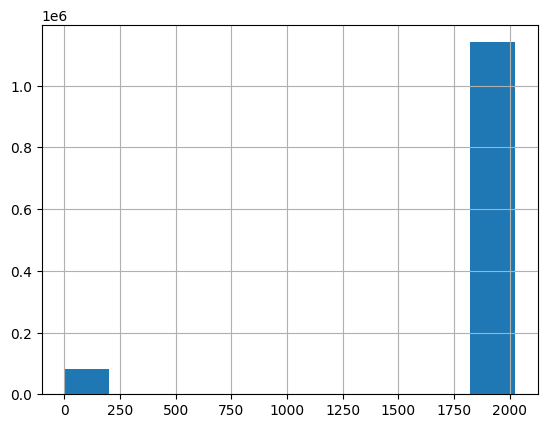

In [4]:
large_df['YEAR_BUILT'].hist()

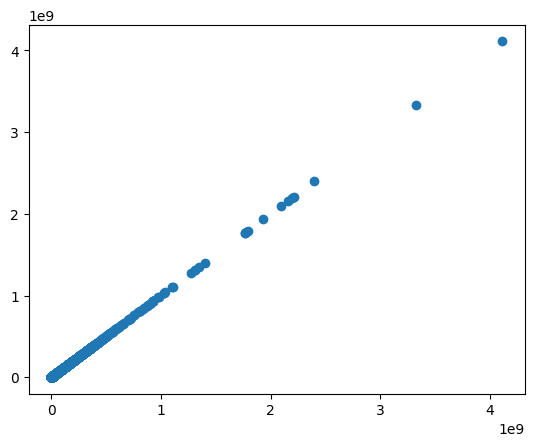

In [5]:
plt.scatter(large_df['SALE_PRICE'],large_df['SALE_PRICE'])

<Axes: >

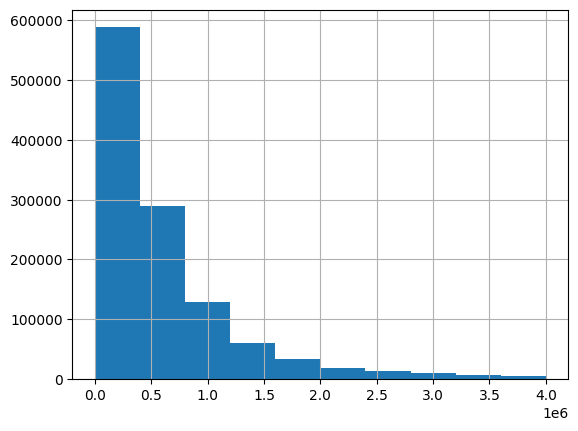

In [6]:
limited_sales = large_df[large_df['SALE_PRICE']<4000000]
limited_sales['SALE_PRICE'].hist()

### Removing Nulls

We identified and removed null values.

In [2]:
# check for nulls
large_df.isnull().sum()

BOROUGH                         0
NEIGHBORHOOD                    0
BUILDING_CLASS_CATEGORY         0
ADDRESS                         0
ZIP_CODE                       49
LAND_SQUARE_FEET           263409
GROSS_SQUARE_FEET          268968
YEAR_BUILT                  34257
SALE_PRICE                  55246
SALE_DATE                       0
dtype: int64

In [3]:
# drop rows with null (including square footage because there would remain a lot of data points)
large_df = large_df.dropna(axis=0, subset=['LAND_SQUARE_FEET', 'GROSS_SQUARE_FEET', 'YEAR_BUILT', 'SALE_PRICE', 'SALE_DATE', 'ZIP_CODE'])

### Manual Outlier Removal

We manually removed outliers we identified in our visualizations.

In [4]:
# remove rows where sale price is less than 1000
large_df=large_df[large_df["SALE_PRICE"] > 1000]

# remove rows where year built is less than 1492
large_df=large_df[large_df["YEAR_BUILT"] > 1492]

In [6]:
%pip install pyarrow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.1/42.1 MB 59.3 MB/s eta 0:00:00:00:0100:01
Note: you may need to restart the kernel to use updated packages.


In [ ]:
# DO NOT RUN, if you do, delete large_df.csv
# large_df.to_csv("large_df.csv", index=False)

# # Write the DataFrame to a Feather file
# large_df.to_feather("large_df.feather")

# print("Files 'large_df.csv' and 'large_df.feather' have been saved.")

Files 'large_df.csv' and 'large_df.feather' have been saved.


In [7]:
large_df = pd.read_feather("large_df.feather")

# Display the first few rows of the DataFrame to confirm it loaded correctly
print("New DataFrame loaded from 'large_df.feather':")
large_df.head()

New DataFrame loaded from 'large_df.feather':


,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,ADDRESS,ZIP_CODE,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,SALE_PRICE,SALE_DATE
1,2.00,BATHGATE,01 ONE FAMILY HOMES,441 EAST 178 STREET,"10,457.00","1,287.00","2,378.00","1,899.00","116,000.00",7/1/2010
2,2.00,BATHGATE,01 ONE FAMILY HOMES,4428 PARK AVENUE,"10,457.00","3,525.00","1,340.00","1,899.00","287,000.00",12/10/2010
3,2.00,BATHGATE,01 ONE FAMILY HOMES,467 EAST 185 STREET,"10,458.00","1,667.00","1,296.00","1,910.00","150,000.00",4/20/2010
4,2.00,BATHGATE,01 ONE FAMILY HOMES,2085 BATHGATE AVENUE,"10,457.00","2,060.00","1,629.00","1,899.00","145,915.00",7/27/2010
5,2.00,BATHGATE,01 ONE FAMILY HOMES,2069 BATHGATE AVENUE,"10,457.00","1,964.00","1,424.00","1,899.00","72,790.00",6/3/2010


In [8]:
large_df.info

<bound method DataFrame.info of          BOROUGH               NEIGHBORHOOD  \
1           2.00  BATHGATE                    
2           2.00  BATHGATE                    
3           2.00  BATHGATE                    
4           2.00  BATHGATE                    
5           2.00  BATHGATE                    
...          ...                        ...   
1256133     5.00                    WOODROW   
1256134     5.00                    WOODROW   
1256136     5.00                    WOODROW   
1256137     5.00                    WOODROW   
1256140     5.00                    WOODROW   

                              BUILDING_CLASS_CATEGORY  \
1        01  ONE FAMILY HOMES                           
2        01  ONE FAMILY HOMES                           
3        01  ONE FAMILY HOMES                           
4        01  ONE FAMILY HOMES                           
5        01  ONE FAMILY HOMES                           
...                                               ...   
1256

### Merged Stock Price Dataset

We merged the stock price data with our dataset, in order to analyze the effect of stock price on sale price. Preprocessed the data and ensured that the date column in both datasets is in the same format. Feature engineered a new month column and removed NA values.

In [11]:

import pandas as pd
import glob

# File paths for uploaded data
file_paths = [
    "/workspaces/student-group-project-jxckj/_datasets/sp500/sp500-2010.csv",
    "/workspaces/student-group-project-jxckj/_datasets/sp500/sp500-2011.csv",
    "/workspaces/student-group-project-jxckj/_datasets/sp500/sp500-2012.csv",
    "/workspaces/student-group-project-jxckj/_datasets/sp500/sp500-2013.csv",
    "/workspaces/student-group-project-jxckj/_datasets/sp500/sp500-2014.csv",
    "/workspaces/student-group-project-jxckj/_datasets/sp500/sp500-2015.csv",
    "/workspaces/student-group-project-jxckj/_datasets/sp500/sp500-2016.csv",
    "/workspaces/student-group-project-jxckj/_datasets/sp500/sp500-2017.csv",
    "/workspaces/student-group-project-jxckj/_datasets/sp500/sp500-2018.csv",
    "/workspaces/student-group-project-jxckj/_datasets/sp500/sp500-2019.csv",
    "/workspaces/student-group-project-jxckj/_datasets/sp500/sp500-2020.csv",
    "/workspaces/student-group-project-jxckj/_datasets/sp500/sp500-2021.csv",
    "/workspaces/student-group-project-jxckj/_datasets/sp500/sp500-2022.csv",
    "/workspaces/student-group-project-jxckj/_datasets/sp500/sp500-2023.csv",
    "/workspaces/student-group-project-jxckj/_datasets/sp500/sp500-2024.csv",
    
]

# Read and combine data
dfs = []
for file in file_paths:
    if file.endswith(".xlsx"):
        df = pd.read_excel(file)
    else:
        df = pd.read_csv(file)
    
    dfs.append(df)

# Concatenate all dataframes
sp500_data = pd.concat(dfs, ignore_index=True)
sp500_data_cleaned = sp500_data.drop_duplicates().dropna()

large_df.loc[:, "SALE_DATE"] = pd.to_datetime(large_df["SALE_DATE"], errors='coerce')
sp500_data_cleaned.loc[:, "Date"] = pd.to_datetime(sp500_data_cleaned["Date"], errors="coerce")

large_df['SALE_DATE'] = pd.to_datetime(large_df['SALE_DATE'], errors='coerce')
sp500_data_cleaned['Date'] = pd.to_datetime(sp500_data_cleaned['Date'], errors='coerce')

merged_df = large_df.merge(sp500_data_cleaned, left_on="SALE_DATE", right_on="Date", how="left")
merged_df["Date"] = pd.to_datetime(merged_df["Date"], errors="coerce")

merged_df = merged_df.dropna(subset=["Date"])

merged_df["Close_Month"] = merged_df["Date"].dt.month.astype(int).astype(str).str.zfill(2)
merged_df['Close'] = merged_df['Close'].astype(str).str.replace(',', '').astype(float)
merged_df['SALE_PRICE'] = merged_df['SALE_PRICE'].astype(str).str.replace(',', '').astype(float)

The correlation matrix and visualizations indicates that there is a positive relationship between average monthly closing prices and sale prices.

Correlation between Average Monthly Closing Prices and Sale Prices:
            Close  SALE_PRICE
Close        1.00        0.51
SALE_PRICE   0.51        1.00


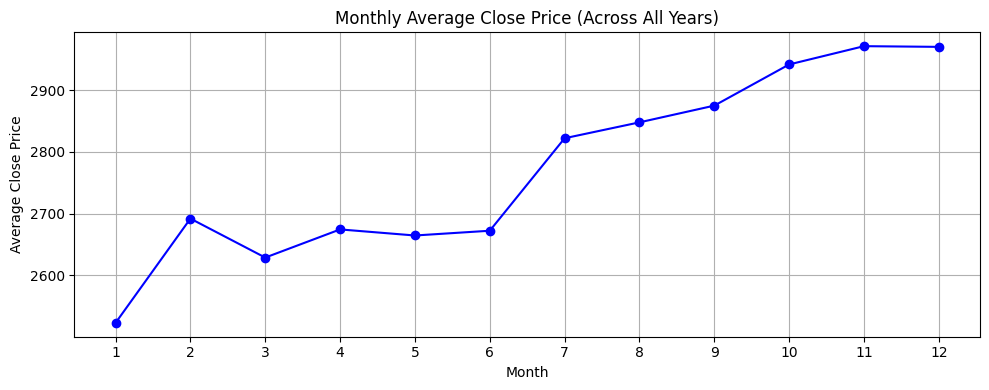

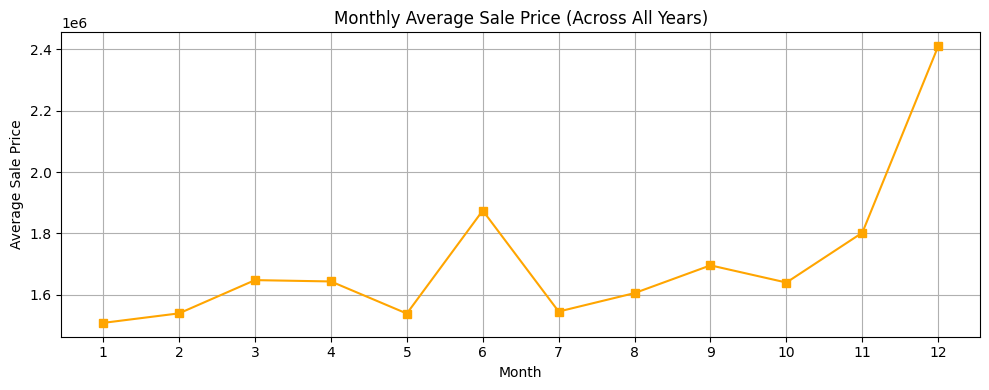

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# pre 
merged_df['SALE_DATE'] = pd.to_datetime(merged_df['SALE_DATE'], errors='coerce')

# drop na for missing data
merged_df = merged_df.dropna(subset=['SALE_DATE'])

# pull out the month
merged_df['Month'] = merged_df['SALE_DATE'].dt.month

# find the average out by grouping month for close and sale price
monthly_avg = merged_df.groupby('Month')[['Close', 'SALE_PRICE']].mean()

# correletion 
correlation = monthly_avg.corr()
print("Correlation between Average Monthly Closing Prices and Sale Prices:")
print(correlation)

# plot 1 average of monthly close price
plt.figure(figsize=(10, 4))
plt.plot(monthly_avg.index, monthly_avg['Close'], marker='o', color='blue')
plt.title("Monthly Average Close Price (Across All Years)")
plt.xlabel("Month")
plt.ylabel("Average Close Price")
plt.xticks(range(1, 13))
plt.grid(True)
plt.tight_layout()
plt.show()

#plot 2 average of monthly sale price
plt.figure(figsize=(10, 4))
plt.plot(monthly_avg.index, monthly_avg['SALE_PRICE'], marker='s', color='orange')
plt.title("Monthly Average Sale Price (Across All Years)")
plt.xlabel("Month")
plt.ylabel("Average Sale Price")
plt.xticks(range(1, 13))
plt.grid(True)
plt.tight_layout()
plt.show()


### Merged Interest Rate Data

Merged the interest rate datasets with the real estate dataset. We also did some feature engineering to get year and month columns.

In [12]:
import pandas as pd
interest_df = pd.read_csv("/workspaces/student-group-project-jxckj/_datasets/FEDFUNDS-2.csv")
# Convert observation_date to datetime format
interest_df['observation_date'] = pd.to_datetime(interest_df['observation_date'])
# Rename the column FEDFUNDS to interest_rate
interest_df.rename(columns={'FEDFUNDS': 'interest_rate'}, inplace=True)
# Create year and month columns
interest_df['year'] = interest_df['observation_date'].dt.year
interest_df['month'] = interest_df['observation_date'].dt.month
interest_df.head()

,observation_date,interest_rate,year,month
0,2010-01-01,0.11,2010,1
1,2010-02-01,0.13,2010,2
2,2010-03-01,0.16,2010,3
3,2010-04-01,0.20,2010,4
4,2010-05-01,0.20,2010,5


This is a visualization of the interests rates over time that reveals that interest rates have fluctuated recently, especially after covid they increased immensely.

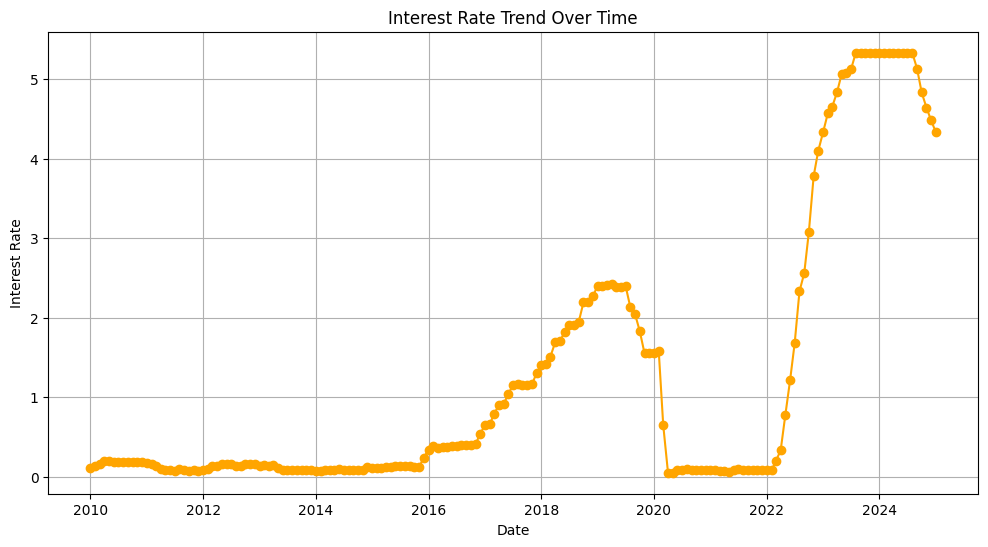

In [13]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.plot(interest_df['observation_date'], interest_df['interest_rate'], marker='o', linestyle='-', color='orange')
plt.xlabel("Date")
plt.ylabel("Interest Rate")
plt.title("Interest Rate Trend Over Time")
plt.grid(True)
plt.show()

These line plots indicate that as interests rates change, there is not a signifcant change in sale prices. This reveals that interests rates don't have a significant impact on sale price.

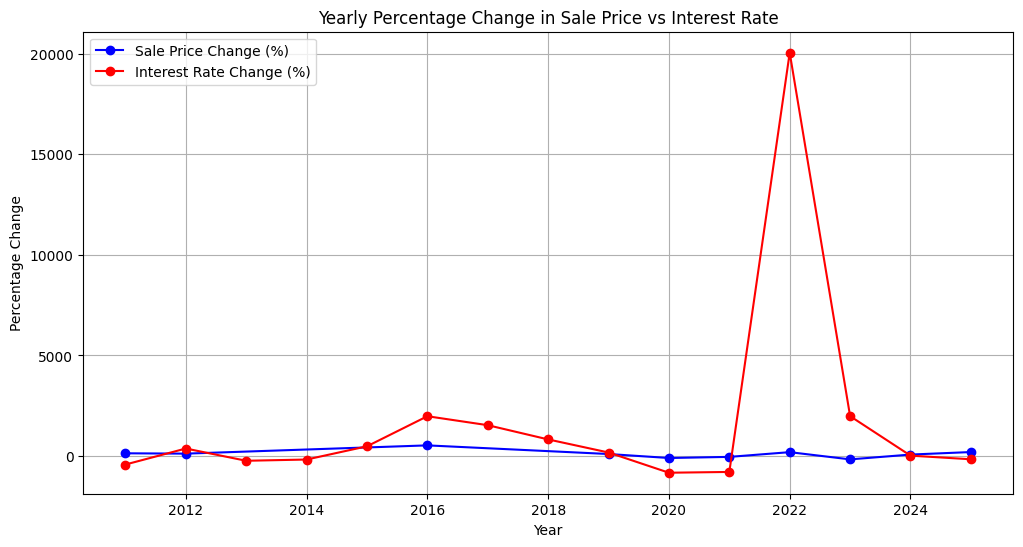

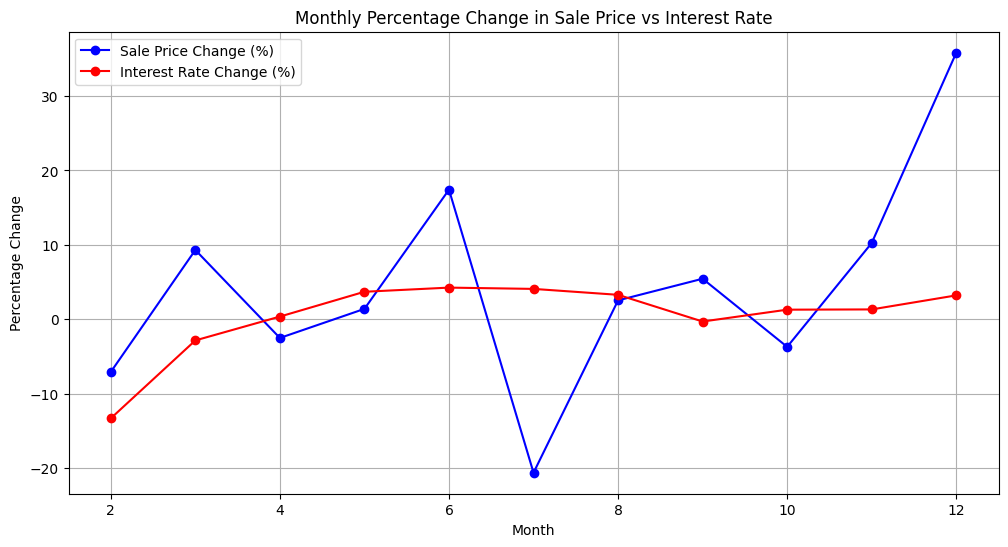

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


# Extract year and month
large_df['year'] = large_df['SALE_DATE'].dt.year
large_df['month'] = large_df['SALE_DATE'].dt.month
interest_df['year'] = interest_df['observation_date'].dt.year
interest_df['month'] = interest_df['observation_date'].dt.month


# Aggregate average sale price and interest rate by year
yearly_sale_price = large_df.groupby('year')['SALE_PRICE'].mean()
yearly_interest_rate = interest_df.groupby('year')['interest_rate'].mean()


# Aggregate average sale price and interest rate by month (across all years)
monthly_sale_price = large_df.groupby('month')['SALE_PRICE'].mean()
monthly_interest_rate = interest_df.groupby('month')['interest_rate'].mean()


# Calculate Yearly and Monthly Percentage Change for Sale Price
yearly_sale_price_change = yearly_sale_price.pct_change() * 1000  # Convert to percentage，then we can see the 
monthly_sale_price_change = monthly_sale_price.pct_change() * 100


# Calculate Yearly and Monthly Percentage Change for Interest Rate
yearly_interest_rate_change = yearly_interest_rate.pct_change() * 1000
monthly_interest_rate_change = monthly_interest_rate.pct_change() * 100


# Plot: Yearly Percentage Change in Sale Price vs Interest Rate
plt.figure(figsize=(12, 6))
plt.plot(yearly_sale_price_change.index, yearly_sale_price_change.values, marker='o', linestyle='-', color="blue", label="Sale Price Change (%)")
plt.plot(yearly_interest_rate_change.index, yearly_interest_rate_change.values, marker='o', linestyle='-', color="red", label="Interest Rate Change (%)")
plt.xlabel("Year")
plt.ylabel("Percentage Change")
plt.title("Yearly Percentage Change in Sale Price vs Interest Rate")
plt.legend()
plt.grid(True)
plt.show()


# Plot: Monthly Percentage Change in Sale Price vs Interest Rate
plt.figure(figsize=(12, 6))
plt.plot(monthly_sale_price_change.index, monthly_sale_price_change.values, marker='o', linestyle='-', color="blue", label="Sale Price Change (%)")
plt.plot(monthly_interest_rate_change.index, monthly_interest_rate_change.values, marker='o', linestyle='-', color="red", label="Interest Rate Change (%)")
plt.xlabel("Month")
plt.ylabel("Percentage Change")
plt.title("Monthly Percentage Change in Sale Price vs Interest Rate")
plt.legend()
plt.grid(True)
plt.show()

### Geocoding

Next we were able to get the latitude and longitude data by cleaning the addresses and merging our dataset with a nyc dataset. This merging process only applied to over 250,000 rows, essentially cutting our data in half.  

In [ ]:
import re

add_filtered = pd.read_csv("/workspaces/student-group-project-jxckj/_datasets/cleaned_addresses.csv")
add_filtered = add_filtered.dropna(subset=['latitude', 'longitude', 'borocode', 'zipcode', 'address'])
add_filtered.drop(['xcoord','ycoord'], axis=1)

# Function to clean and standardize addresses
def clean_address(address):
    if isinstance(address, str):  
        address = address.lower().strip()  
        address = " ".join(address.split()) 
        replacements = {
            " street": " st",
            " avenue": " ave",
            " boulevard": " blvd",
            " place": " pl",
            " road": " rd",
            " drive": " dr",
            " lane": " ln",
            " court": " ct",
            " parkway": " pkwy",
            " highway": " hwy"
        }

        for key, value in replacements.items():
            address = address.replace(key, value)
        
        address = address.replace(",", "").replace(".", "").replace("#", "")

    return address

add_filtered['address_clean'] = add_filtered['address'].apply(clean_address)
large_df['address_clean'] = large_df['ADDRESS'].apply(clean_address)

geo_df = pd.merge(
    add_filtered,large_df,
    left_on=['address_clean', 'zipcode'],
    right_on=['address_clean', 'ZIP_CODE'],
    how='inner'
)
geo_df.head()

,latitude,longitude,borocode,xcoord,ycoord,zipcode,address,address_clean,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,ADDRESS,ZIP_CODE,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,SALE_PRICE,SALE_DATE,PRICE_CATEGORY
0,40.63,-73.95,3,"997,114.00","167,268.00","11,210.00",2220 AVENUE J,2220 ave j,3.00,MIDWOOD,01 ONE FAMILY HOMES,2220 AVENUE J,"11,210.00","5,000.00","3,322.00","1,920.00","1,510,000.00",1/24/2012,1
1,40.62,-73.96,3,"996,105.00","166,233.00","11,230.00",1820 AVENUE K,1820 ave k,3.00,MIDWOOD,01 ONE FAMILY DWELLINGS,1820 AVENUE K,"11,230.00","4,000.00","2,466.00","1,899.00","1,800,000.00",06/27/2024,1
2,40.63,-73.92,3,"1,005,754.00","168,527.00","11,234.00",1098 EAST 56TH STREET,1098 east 56th st,3.00,FLATLANDS,41 TAX CLASS 4 - OTHER,1098 EAST 56TH STREET,"11,234.00","3,575.00",0.00,"1,975.00","665,000.00",12/13/2022,1
3,40.62,-73.92,3,"1,006,754.00","166,750.00","11,234.00",5823 AVENUE L,5823 ave l,3.00,FLATLANDS,02 TWO FAMILY DWELLINGS,5823 AVENUE L,"11,234.00","2,033.00","1,216.00","1,925.00","636,540.00",11/22/2021,1
4,40.62,-73.92,3,"1,005,100.00","165,627.00","11,234.00",5206 AVENUE M,5206 ave m,3.00,OLD MILL BASIN,01 ONE FAMILY DWELLINGS,5206 AVE M,"11,234.00","2,000.00","1,034.00","1,920.00","380,000.00",12/06/2024,0
